In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
#use random state 1

In [122]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    '''Prints the AUC scores for training and testing data
    and returns testing score'''

    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    print('Training AUC:' , roc_auc_score(y_train, y_train_score))
    print('Testing AUC: ', roc_auc_score(y_test, y_test_score))
 
    return y_test_score

def plot_roc_curve(y_test, y_test_score):
    '''Plot ROC curve for testing data'''
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k — ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

#https://medium.com/swlh/how-to-code-and-evaluate-of-decision-trees-2d94093b3c1a

In [123]:
path = pd.read_csv("../Data/cleansed_final.csv")

In [124]:
path

,resp_label,Side1,OverallGroupStage,AngiolymphInvasion,InvasiveGrowthPattern,MSI,Plasma,GarlandNecrosis,Mucinous,SignetRing,...,ModDiff,TILS,HistHet,RightSide,NoNecrosis,Signet,Mucin,AngioLymph,Expansile,Stage12
0,18872,Left,III,No,Invasive,0,Not prominent,Yes(Focal),No,No,...,0,0,0,0,0,0,0,0,0,0
1,14812,Left,II,Yes,Invasive,0,NaN,Yes,No,No,...,0,0,0,0,0,0,0,1,0,1
2,14745,Left,II,No,Invasive,0,NaN,Yes(Focal),No,No,...,1,0,0,0,0,0,0,0,0,1
3,15379,Left,I,No,Expansile,1,Prominent,No,Yes(Focal),No,...,0,1,0,0,1,0,1,0,1,1
4,14564,Right,II,No,Expansile,0,NaN,Yes,No,No,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,13839,Left,II,No,Expansile,0,NaN,No,No,No,...,1,0,0,0,1,0,0,0,1,1
1906,11707,Left,II,No,Expansile,1,NaN,Yes,No,No,...,0,1,0,0,0,0,0,0,1,1
1907,11140,Right,II,No,Invasive,0,Not prominent,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1
1908,15289,Left,II,No,Invasive,0,Not prominent,Yes,No,No,...,0,0,0,0,0,0,0,0,0,1


In [125]:
final = path[["MSI","Under50","TILS", "Stage12", "Signet", "RightSide","NoNecrosis", "Mucin", "ModDiff", "HistHet", "Female", "Expansile", "CrohnMissing", "Crohn", "AngioLymph"]]

In [126]:
# dont use NoNecrosis; turn the feature handling around

In [127]:
final

,MSI,Under50,TILS,Stage12,Signet,RightSide,NoNecrosis,Mucin,ModDiff,HistHet,Female,Expansile,CrohnMissing,Crohn,AngioLymph
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0
4,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0
1906,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0
1907,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1908,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [128]:
## fix random seed
import random
random.seed(222)

In [129]:
X = final.drop("MSI", axis=1)

In [130]:
y = final["MSI"]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=.3, random_state=1)

In [132]:
## use smote to deal with imbalanced data by oversampling
oversample = SMOTE(random_state = 1)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

## Multilayer Perceptron

In [135]:
mlp_gs = MLPClassifier(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(15,15,2), (20,20,2)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_smote, y_smote) # X is train samples and y is the corresponding labels

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (15, 15, 2),
                                                (20, 20, 2)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [136]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


We found that the grid search parameters were overfitting the training data, so we had decided to use the below paramters to train the MLP.

In [142]:
mlp = MLPClassifier(solver='adam', activation='relu', max_iter=200,alpha=1e-4,
                    hidden_layer_sizes=(15,15,2), random_state=1, verbose=True, early_stopping=True)

mlp.fit(X_smote, y_smote)

Iteration 1, loss = 0.69866104
Validation score: 0.468468
Iteration 2, loss = 0.69044461
Validation score: 0.495495
Iteration 3, loss = 0.68358628
Validation score: 0.540541
Iteration 4, loss = 0.67731541
Validation score: 0.563063
Iteration 5, loss = 0.67114961
Validation score: 0.599099
Iteration 6, loss = 0.66531233
Validation score: 0.630631
Iteration 7, loss = 0.65879287
Validation score: 0.621622
Iteration 8, loss = 0.65292901
Validation score: 0.630631
Iteration 9, loss = 0.64742331
Validation score: 0.626126
Iteration 10, loss = 0.64135835
Validation score: 0.621622
Iteration 11, loss = 0.63580725
Validation score: 0.635135
Iteration 12, loss = 0.63035125
Validation score: 0.639640
Iteration 13, loss = 0.62539028
Validation score: 0.648649
Iteration 14, loss = 0.62065378
Validation score: 0.657658
Iteration 15, loss = 0.61683319
Validation score: 0.657658
Iteration 16, loss = 0.61324454
Validation score: 0.666667
Iteration 17, loss = 0.61023888
Validation score: 0.671171
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(15, 15, 2),
              random_state=1, verbose=True)

Training AUC: 0.7906228326155131
Testing AUC:  0.7032747399169784


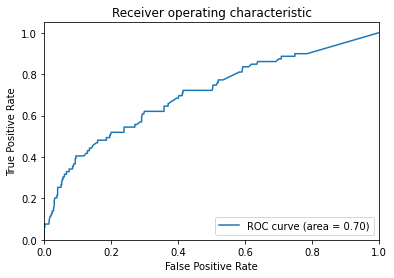

In [143]:
## AUC ROC curve
y_test_score = get_auc_scores(mlp, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

In [145]:
features = list(X_test.columns)

In [146]:
imps = permutation_importance(mlp, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. NoNecrosis (0.033159)
2. RightSide (0.012914)
3. Female (0.008028)
4. TILS (0.003141)
5. CrohnMissing (0.000000)
6. Under50 (0.000000)
7. Signet (-0.000698)
8. HistHet (-0.003141)
9. Mucin (-0.004538)
10. ModDiff (-0.006632)
11. Stage12 (-0.013264)
12. AngioLymph (-0.014311)
13. Crohn (-0.014311)
14. Expansile (-0.026527)


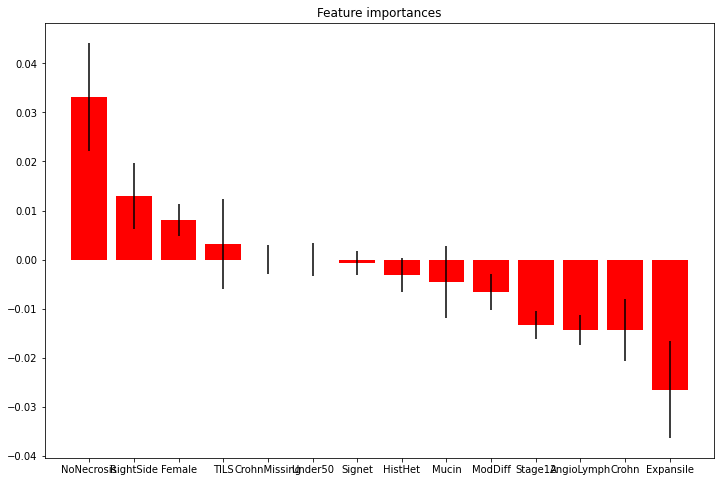

In [147]:
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(14)])
plt.xlim([-1, X_test.shape[1]])
plt.show()